<h2> <span style="color:blue;">Recommender System:- </span></h2>

In our previous notebook, we explored the basic concept of recommender systems, including various types and even built three of them. However, using the previous data to create a collaborative filtering system wasn't feasible. Therefore, in this notebook, we'll use "fastai" to download movie data (<i>you can also download the data directly and use it</i>) and then we will build a collaborative recommender system. If you find this notebook helpful then feel free to use this code to build your own. Happy learning!!

<h3> <span style="color:green;">What is Collaborative Filtering</span></h3> 
Collaborative filtering is a technique used by recommender systems to predict a user's preferences or interests by gathering preferences or information from many users (collaborating). This technique assumes that if two users have similar preferences for some items, they are likely to have similar preferences for other items as well. <h4><b><span style="color:brown;">Example:</span></b></h4>
Let's say you have two friends, Ratna and Dipesh, who share similar movie preferences. Dipesh tells you he enjoyed a movie called "OMG2," and you know Ratna hasn't watched it. So, you suggest the movie to Ratna because there's a good chance she will also enjoy it. Collaborative filtering applies this idea to a larger scale, known as "Group Wisdom," where it looks at what many users like and dislike, finding patterns among their preferences. Then, when you're seeking something new to watch or listen to, collaborative filtering recommends things based on what people with similar tastes have enjoyed in the past.

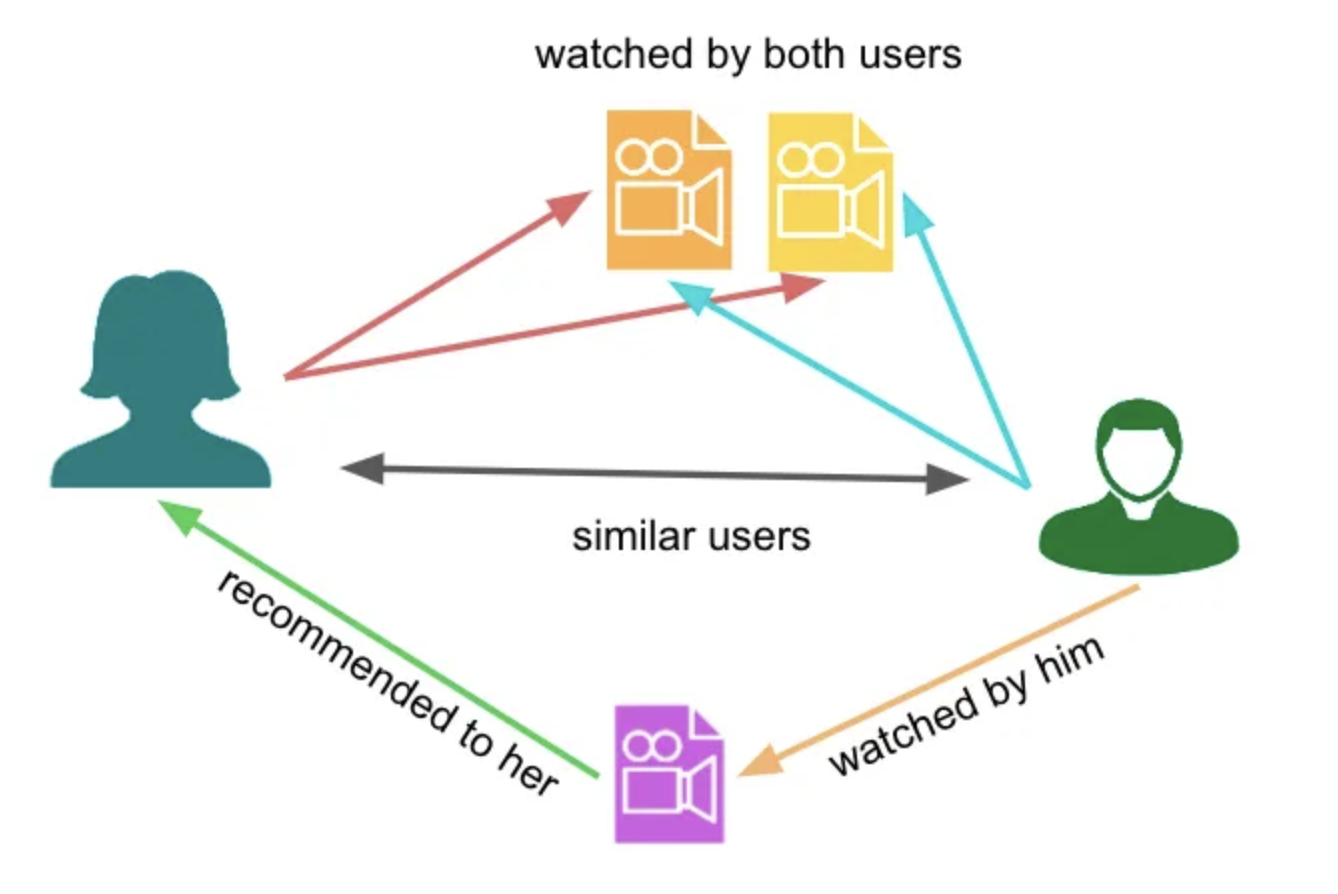

<i>Image source - Medium<i>

<h1> <span style="color:red;"> Step 1:- Prepare Data</span></h1>

In [1]:
import ssl
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from fastai.collab import *
from fastai.tabular.all import *
from surprise import Dataset, Reader, SVD, NMF
from surprise.model_selection import train_test_split
from surprise import accuracy

In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
path = untar_data(URLs.ML_100k)

Lets convert all the required data into proper format. While downloading we got many files but we only need 3 of them .Basic infos of those 3 files,

<ol>
    <li><b>u.item-></b></li> Information about the items (movies); this is a tab separated list of,
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.
    <li><b>u.user-></b></li> Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.
    <li><b>u.data-></b></li> The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are numbered consecutively from 1.  The data is randomly ordered. This is a tab separated list of,<br> 
	         user id | item id | rating | timestamp <br> 
             The time stamps are unix seconds since 1/1/1970 UTC
</ol>

In [3]:
movie_columns = ['movie_id','movie_title','release_date','video_release_date','url','unknown','action',\
                 'adventure','animation','for_kids','comedy','crime','documentary','drama','fantasy',\
                 'film_noir','horror','musical','mystery','romance','sci_fi','thriller','war','western']
user_columns = ['user_id','age','gender','occupation','zip_code']
user_rating_columns = ['user_id','movie_id','rating','timestamp']

In [4]:
movies_df = pd.read_csv(path/'u.item', delimiter='|', header=None, names=movie_columns, encoding = 'latin-1')
users_df = pd.read_csv(path/'u.user', delimiter='|', header=None, names=user_columns)
user_ratings_df = pd.read_csv(path/'u.data', delimiter='\t', header=None,names=user_rating_columns)

In [5]:
movies_df.shape[0],users_df.shape[0],user_ratings_df.shape[0]

(1682, 943, 100000)

In [6]:
movies_df.head(2)
# as we can see not all columns are important so we can drop release_date, video_release_date, url columns

,movie_id,movie_title,release_date,video_release_date,url,unknown,action,adventure,animation,for_kids,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
users_df.head(2)

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [8]:
user_ratings_df.head(2) # Looks like we have Unix timestamps, we will convert them to datetime objects
user_ratings_df['timestamp']=pd.to_datetime(user_ratings_df['timestamp'], unit='s')

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Merge the dataframes to create a single user-item dataframe</span></h3> 

In [9]:
merged_user_df = pd.merge(users_df,user_ratings_df,how='inner',on='user_id')

In [10]:
merged_df=pd.merge(merged_user_df,movies_df,how='inner',on='movie_id')

In [11]:
merged_df[merged_df['user_id']==1].sort_values(by='movie_id').head(3)

,user_id,age,gender,occupation,zip_code,movie_id,rating,timestamp,movie_title,release_date,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
26054,1,24,M,technician,85711,1,5,1997-09-22 22:02:38,Toy Story (1995),01-Jan-1995,...,0,0,0,0,0,0,0,0,0,0
22985,1,24,M,technician,85711,2,3,1997-10-15 05:26:11,GoldenEye (1995),01-Jan-1995,...,0,0,0,0,0,0,0,1,0,0
39333,1,24,M,technician,85711,3,4,1997-11-03 07:42:40,Four Rooms (1995),01-Jan-1995,...,0,0,0,0,0,0,0,1,0,0


In [12]:
merged_df.shape[0]

100000

In [13]:
merged_df.columns

Index(['user_id', 'age', 'gender', 'occupation', 'zip_code', 'movie_id',
       'rating', 'timestamp', 'movie_title', 'release_date',
       'video_release_date', 'url', 'unknown', 'action', 'adventure',
       'animation', 'for_kids', 'comedy', 'crime', 'documentary', 'drama',
       'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance',
       'sci_fi', 'thriller', 'war', 'western'],
      dtype='object')

<h1> <span style="color:red;"> Step 2:- EDA</span></h1>

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;1. Basic Preprocessing </span></h2> 

In [14]:
merged_df.drop_duplicates(inplace=True)

👇 We will be making some changes in the dataframe so for safety let's keep the original dataframe as is. We will copy the original dataframe to movie_recommender_df. 

In [15]:
movie_recommender_df=merged_df.copy()

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;2. Feature Engineering </span></h2> 

In [16]:
sparsed_columns=['unknown', 'action', 'adventure', 'animation','for_kids', 'comedy', \
                 'crime', 'documentary', 'drama', 'fantasy','film_noir', 'horror', 'musical',\
                 'mystery', 'romance', 'sci_fi','thriller', 'war', 'western']

merged_df['genre'] = merged_df[sparsed_columns].apply(lambda x: ','.join([col for col,\
                                                                          val in x.items() if val == 1]), axis=1)

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Drop Unnecessary Columns</span></h3> 

In [17]:
dropped_feature=['release_date', 'video_release_date', 'url']
merged_df.drop(columns=dropped_feature,inplace=True)
merged_df.drop(columns=sparsed_columns,inplace=True)

To build a recommender system, we need to determine which features are relevant for modeling user preferences and item recommendations. Here's a breakdown of the features you've listed and their relevance:
<ol>
<li><b>user_id:</b></li> Essential for identifying unique users in the system. This is a crucial feature for collaborative filtering as it helps in understanding user behavior and preferences.
<li><b>age:</b></li> Age could potentially provide insights into user preferences based on age groups. It might help in segmenting users for personalized recommendations. Later in visualization, we will check how much impact this feature might have on movie preference.
<li><b>gender:</b></li> Gender can also be a useful feature for segmentation and personalization. It might help in recommending movies that are popular among specific genders or for providing gender-specific recommendations. Just like age for this feature later in visualization, we will check how much impact it might have on movie preference.
<li><b>occupation:</b></li> Occupation can offer insights into users' lifestyles and interests, which could influence movie preferences. Certain occupations might correlate with specific movie genres or types of content consumption. Will check if there is any impact in visualization.
<li><b>zip_code:</b></li> Zip code might provide geographic information, which can be useful for localizing recommendations or understanding regional preferences. However, its utility might be limited compared to other features.
<li><b>movie_id:</b></li> Essential for identifying unique movies in the system. This is a fundamental feature for collaborative filtering, as it helps in understanding item characteristics and user-item interactions.
<li><b>rating:</b></li> The rating provided by users for a movie is a crucial feature for collaborative filtering. It represents user preferences and interactions with movies in the system.
<li><b>movie_title:</b></li> While the movie title itself might not directly contribute to the recommendation process, it could be used for display purposes or for providing additional context to users.
<li><b>genre:</b></li> The genre of a movie is highly relevant for recommendations. It helps in understanding the content and characteristics of movies, and it's essential for content-based filtering and hybrid recommendation approaches.
</ol>
In summary, the user-related features (user_id, age, gender, occupation, zip_code) and movie-related features (movie_id, genre) are particularly relevant for building a recommender system.

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Understand the dataset</span></h3> 

In [18]:
merged_df[merged_df['user_id']==1].head(3)

,user_id,age,gender,occupation,zip_code,movie_id,rating,timestamp,movie_title,genre
0,1,24,M,technician,85711,61,4,1997-11-03 07:33:40,Three Colors: White (1994),drama
59,1,24,M,technician,85711,189,3,1998-03-01 06:15:28,"Grand Day Out, A (1992)","animation,comedy"
125,1,24,M,technician,85711,33,4,1997-11-03 07:38:19,Desperado (1995),"action,romance,thriller"


In [19]:
duplicate_movies=merged_df.groupby('movie_id')['movie_title'].nunique()>1
duplicate_movies[duplicate_movies].sum()

0

👆 Looks like every movie title has a unique movie id, so nothing to fix there.

In [20]:
duplicate_zipcode = merged_df.groupby("user_id")["zip_code"].nunique()>1
duplicate_zipcode[duplicate_zipcode].sum()

0

👆 Looks like every user lives in a unique zip code, so nothing to fix there.

In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      100000 non-null  int64         
 1   age          100000 non-null  int64         
 2   gender       100000 non-null  object        
 3   occupation   100000 non-null  object        
 4   zip_code     100000 non-null  object        
 5   movie_id     100000 non-null  int64         
 6   rating       100000 non-null  int64         
 7   timestamp    100000 non-null  datetime64[ns]
 8   movie_title  100000 non-null  object        
 9   genre        100000 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 8.4+ MB


In [22]:
merged_df.describe()

,user_id,age,movie_id,rating
count,100000.00000,100000.000000,100000.000000,100000.000000
mean,462.48475,32.969850,425.530130,3.529860
std,266.61442,11.562623,330.798356,1.125674
min,1.00000,7.000000,1.000000,1.000000
25%,254.00000,24.000000,175.000000,3.000000
50%,447.00000,30.000000,322.000000,4.000000
75%,682.00000,40.000000,631.000000,4.000000
max,943.00000,73.000000,1682.000000,5.000000


In [23]:
merged_df.isnull().sum() #Check for missing values

user_id        0
age            0
gender         0
occupation     0
zip_code       0
movie_id       0
rating         0
timestamp      0
movie_title    0
genre          0
dtype: int64

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;3. Visualization </span></h2> 

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Separate Dataset For Visualization </span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; We will need to create a few columns for visualization purposes. I do not want to make any changes to the existing dataframe; that’s why we will create a copy of our original dataframe. We will make all the changes in the new dataframe and visualize them.

In [24]:
df_visualization= merged_df.copy()

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Define Color for All Visualization Plots</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Here, we will define a custom color palette and use it throughout the session to keep the colors consistent across all the visualizations.

In [25]:
custom_colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange', 'lightpink']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors) #for matplotlib
sns.set_palette(custom_colors) #for seaborn

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;User Demographics Visualization</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let’s check the distribution of user demographics such as age, gender, and occupation. Visualizing these can provide insights into the user base and their preferences.

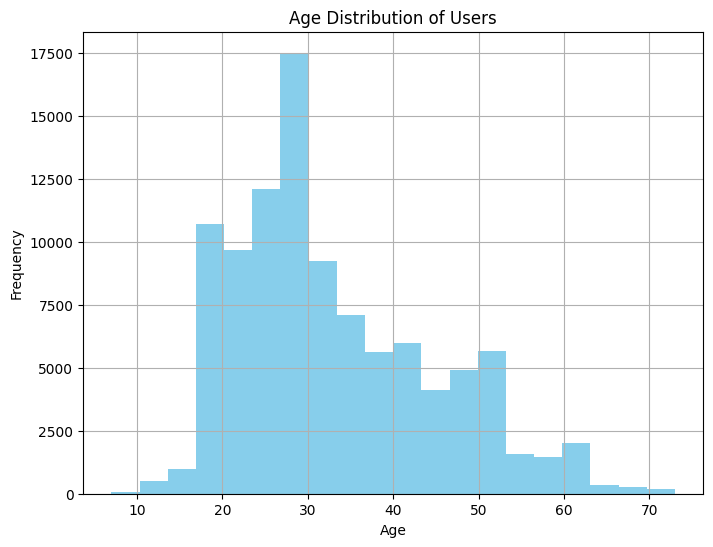

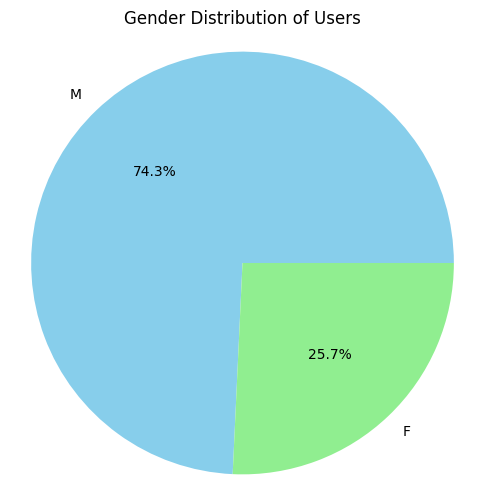

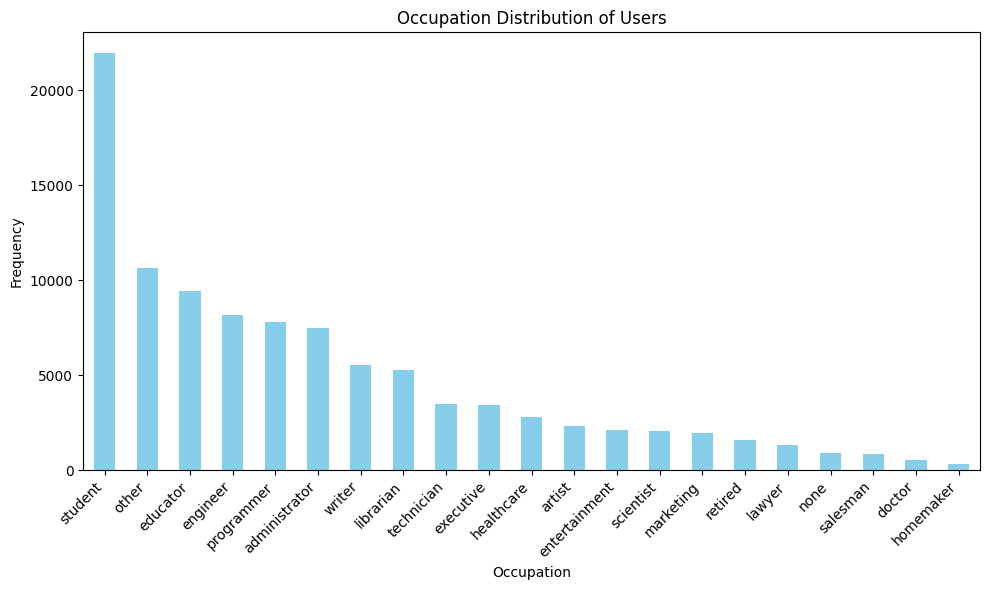

In [26]:
# Visualize Age Distribution
plt.figure(figsize=(8, 6))
plt.hist(df_visualization['age'], bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Users')
plt.grid(True)
plt.show()

# Visualize Gender Distribution
gender_distribution = df_visualization['gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_distribution, labels=gender_distribution.index, autopct='%1.1f%%', )
plt.title('Gender Distribution of Users')
plt.axis('equal')
plt.show()

# Visualize Occupation Distribution
occupation_distribution =df_visualization['occupation'].value_counts()
plt.figure(figsize=(10, 6))
occupation_distribution.plot(kind='bar')
plt.xlabel('Occupation')
plt.ylabel('Frequency')
plt.title('Occupation Distribution of Users')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h3> <span style="color:pink;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. We can see that the most voted groups are in around 18-35 age range.<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. Almost 2/3 of voters are male where 1/3 of voters are female.<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3. Students gave almost double the votes compared to any other occupation.

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Check Rating Outliers</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Check for outliers by visualizing the distribution of numerical columns

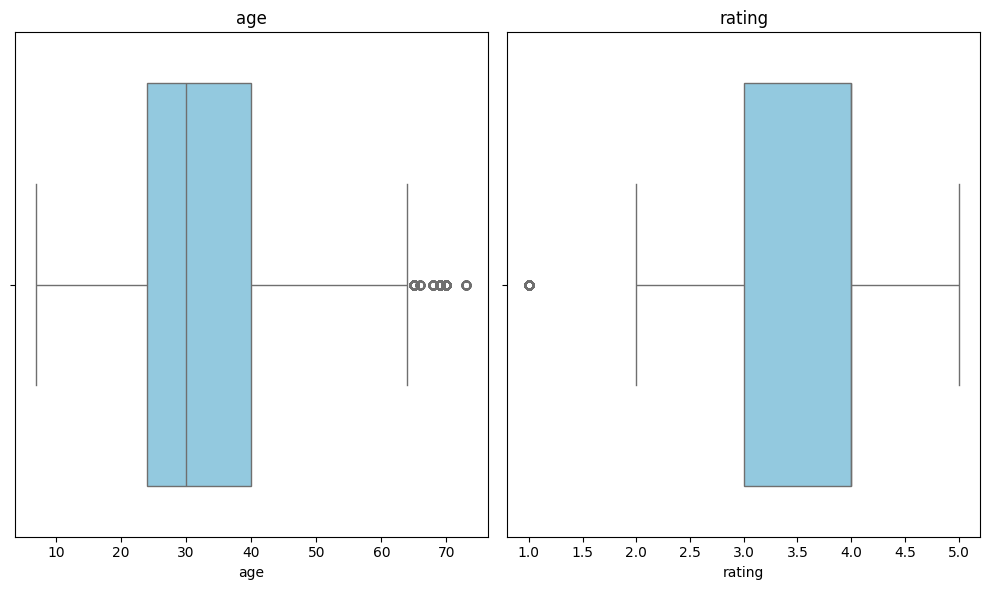

In [27]:
numerical_columns=df_visualization.select_dtypes(include=['int64','float64']).columns
i_counter=1

plt.figure(figsize=(10,6))
for i, col in enumerate(numerical_columns,1):
    if '_id' not in col:
        plt.subplot(1,2,i_counter)
        sns.boxplot(x=df_visualization[col])
        plt.title(col)
        i_counter=i_counter+1
plt.tight_layout()
plt.show()    
    

<h3> <span style="color:pink;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. Very few people above the age of 60 gave movie rating <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. Most people gave ratings between 2 to 5, a rating of 1 is very rare occurrence.

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Visualize the Relationship between Rating and User demographics</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This visualization will help us to identify patterns in ratings based on user demographics. For instance, certain occupations or age groups might consistently rate items higher or lower than others.

<b>Relationship between age and ratings :</b> It is challenging to visualize ratings for every individual age. Therefore, we will create age groups with a maximum 5-year age difference in each group. In the previous "feature engineering" section, we identified the minimum (7) and maximum (73) ages. We will leverage this information to generate our visualization.

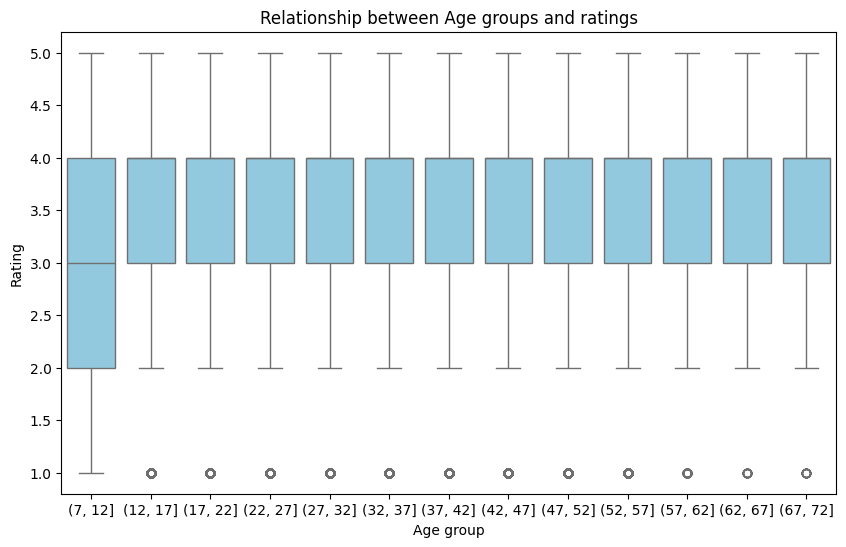

In [28]:
df_visualization['age_group']=pd.cut(df_visualization['age'], range(7, 73, 5))
plt.figure(figsize=(10,6))
sns.boxplot(x='age_group', y='rating', data=df_visualization)
plt.title('Relationship between Age groups and ratings')
plt.xlabel('Age group')
plt.ylabel('Rating')
plt.show()

<h3> <span style="color:pink;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Seems like there are no outliers present for age 7-12; also, the mean rating is different for this group.

<b>Relationship between occupation and ratings :</b> Let's see which occupations tend to give higher ratings and which ones tend to give lower ratings.

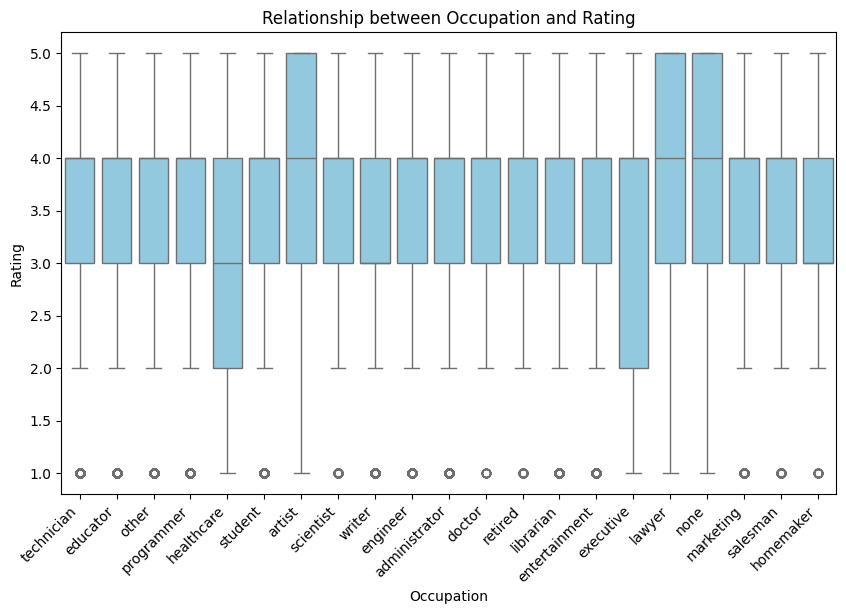

In [29]:
plt.figure(figsize=(10,6))
sns.boxplot(x='occupation',y='rating',data=df_visualization)
plt.xlabel("Occupation")
plt.ylabel("Rating")
plt.title("Relationship between Occupation and Rating")
plt.xticks(rotation=45,ha='right')
plt.show()

<h3> <span style="color:pink;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We can see, on average, that individuals in the “artists”, “lawyers”, and “none” occupations tend to give higher ratings than average, while those in the “healthcare” and “executive” professions tend to give lower ratings than others. Also, for only these 5 groups, no outliers are present; their ratings can range between 1 to 5 (1, 1.5, 2…5). Later, we will check which genre they prefer more.

<b>Relationship between gender and ratings :</b> Let's check if there is any relation between gender and given ratings.

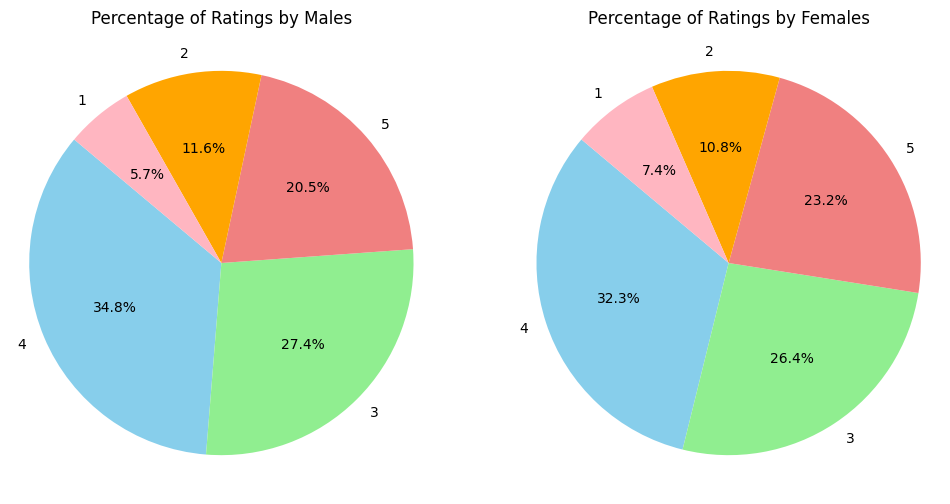

In [30]:
male_ratings = df_visualization[df_visualization['gender'] == 'M'] 
female_ratings = df_visualization[df_visualization['gender'] == 'F']

# Count occurrences of each rating for males and females 
male_rating_counts = male_ratings['rating'].value_counts() 
female_rating_counts = female_ratings['rating'].value_counts()

# Calculate percentage of each rating category for males and females 
male_percentage = (male_rating_counts / male_rating_counts.sum()) * 100 
female_percentage = (female_rating_counts / female_rating_counts.sum()) * 100 
 
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Create two pie charts
# Pie chart for males 
axes[0].pie(male_percentage, labels=male_percentage.index, autopct='%1.1f%%', startangle=140) 
axes[0].set_title('Percentage of Ratings by Males') 
axes[0].axis('equal')
# Pie chart for females 
axes[1].pie(female_percentage, labels=female_percentage.index, autopct='%1.1f%%', startangle=140) 
axes[1].set_title('Percentage of Ratings by Females') 
axes[1].axis('equal');

<h3> <span style="color:pink;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; We can observe that females tend to give both the highest and lowest ratings more frequently than males, whereas males tend to give ratings between 2 and 4 more often than females. However, considering the percentage distribution, we find that they are very similar. Therefore, for now, we can conclude that there is no gender bias in rating behavior.

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Visualize the Relationship between Genre and User demographics</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;By visualizing genre preferences based on demographics, we can personalize recommendations, enhancing user engagement and satisfaction.

<b>Check the Popularity of the Genre:</b> We can recommend genres more frequently based on their popularity.

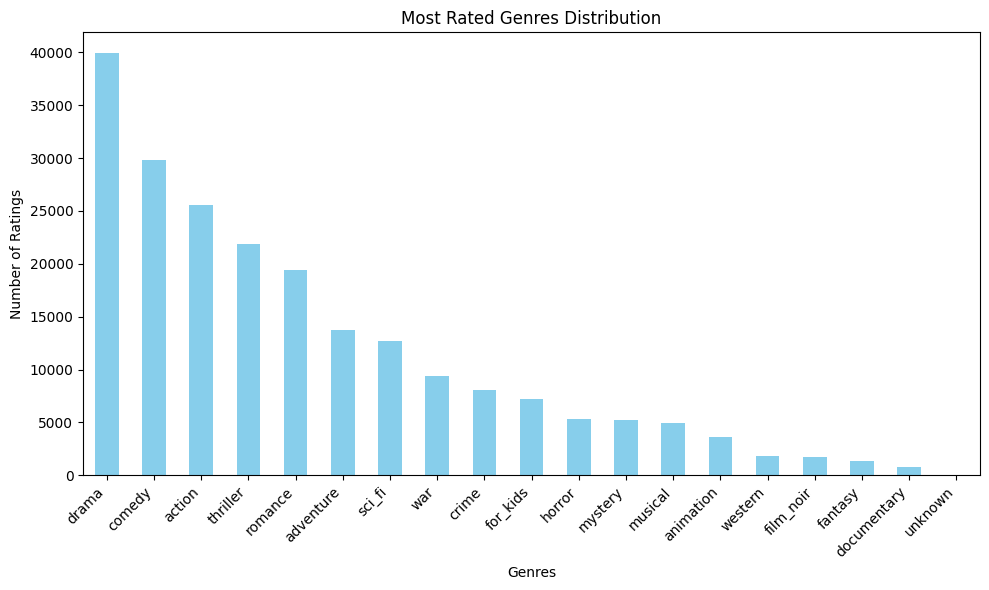

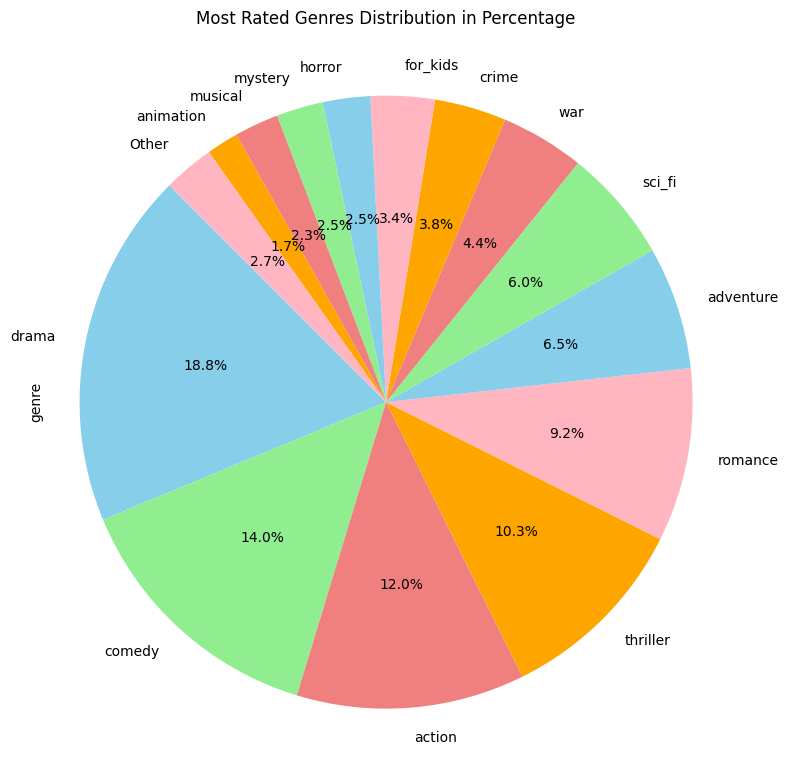

In [31]:
df_visualization['genre'] = df_visualization['genre'].str.split(',')
genres = df_visualization['genre'].explode()
genre_distribution = genres.value_counts() #counts the number of occurrences of each unique genre in the Series and returns a new Series where the index consists of unique genres and the value prepresent the counts of each genre

# Create a bar chart to visualize genre distribution
plt.figure(figsize=(10, 6))
genre_distribution.plot(kind='bar')
plt.xlabel('Genres')
plt.ylabel('Number of Ratings')
plt.title('Most Rated Genres Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# And a pie chart to visualize genre distribution in percentage
total_count = genre_distribution.sum()
genre_distribution_filtered = genre_distribution[genre_distribution / total_count >= 0.01]
genre_distribution_filtered['Other'] = genre_distribution[genre_distribution / total_count < 0.01].sum()

plt.figure(figsize=(8, 8))
genre_distribution_filtered.plot(kind='pie', autopct='%1.1f%%', startangle=135)
plt.title('Most Rated Genres Distribution in Percentage')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

<h3> <span style="color:pink;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; We can see that drama is the most popular genre. Second is comedy, and then action.

<b>Relationship between gender and Genre :</b> Let's see if there is any relation.

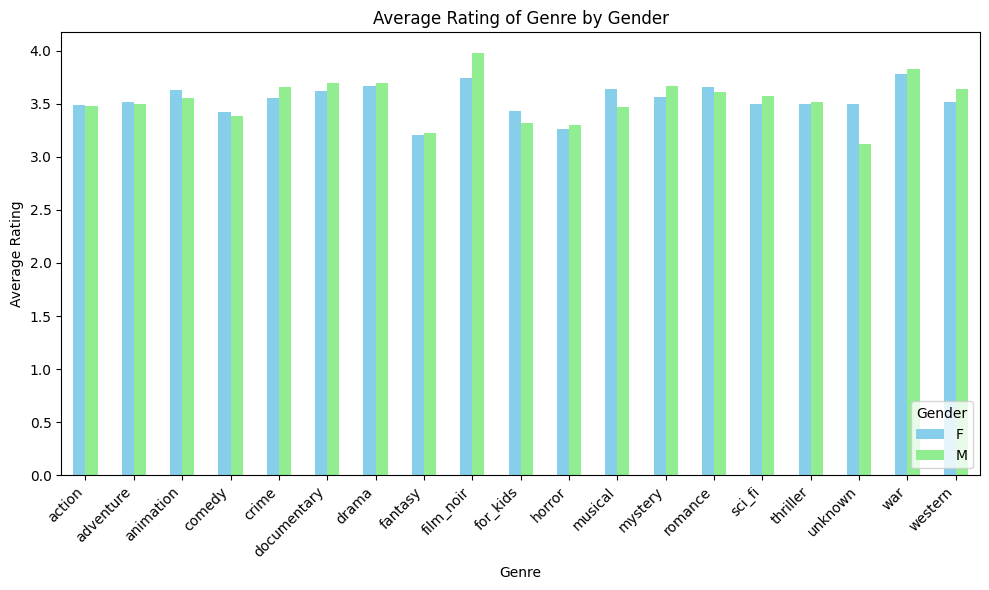

In [32]:
# Group by genre and gender, and calculate the average rating
df_exploded = df_visualization.explode('genre')
genre_gender_avg_rating = df_exploded.groupby(['genre', 'gender'])['rating'].mean().unstack()

# Plot the side-by-side bar chart
genre_gender_avg_rating.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average Rating of Genre by Gender')
plt.legend(title='Gender', loc='lower right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h3> <span style="color:pink;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. Average rating is almost same for both the gender.<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. Film_noir is the top-rated genre among males, while war is the top-rated genre among females, based on average ratings.

<b>Top 2 Genres by Occupation and Age Group :</b> Based on Ratings. In the first graph, we will see the top 2 genres for each occupation. In the second graph, we will explore the top 2 genres for each age group.

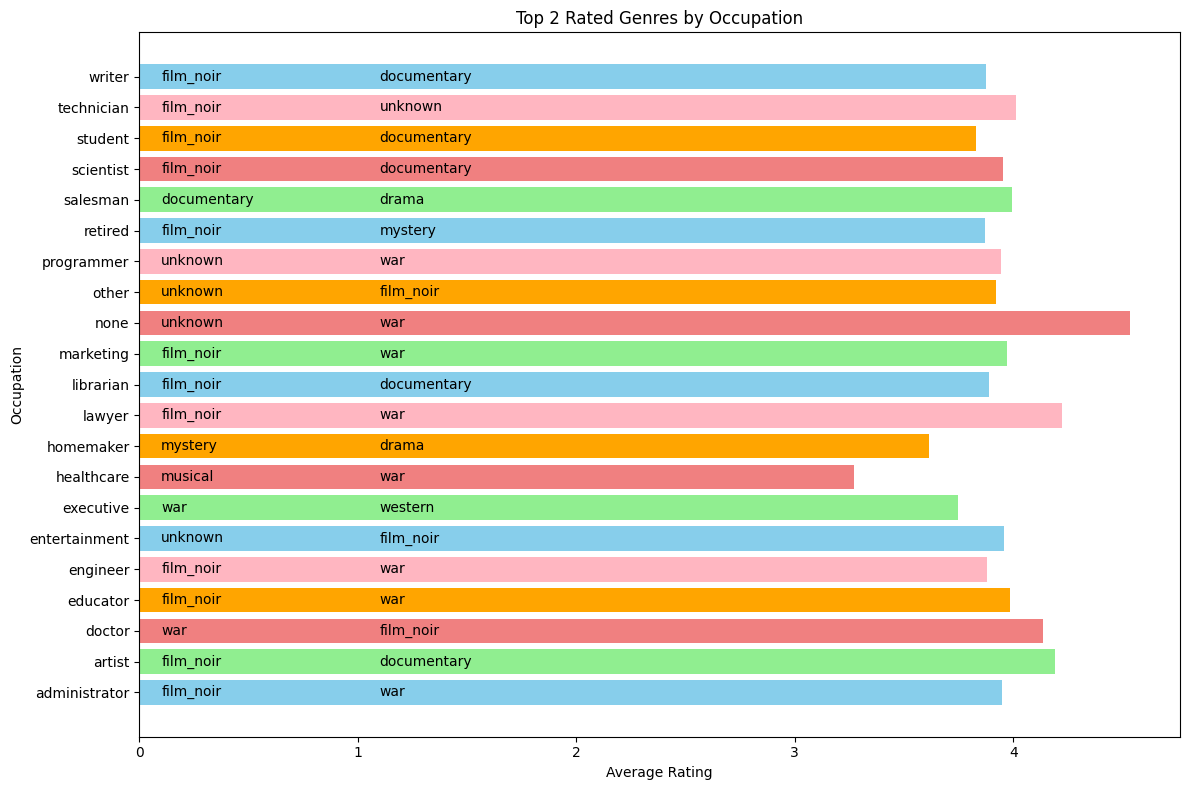

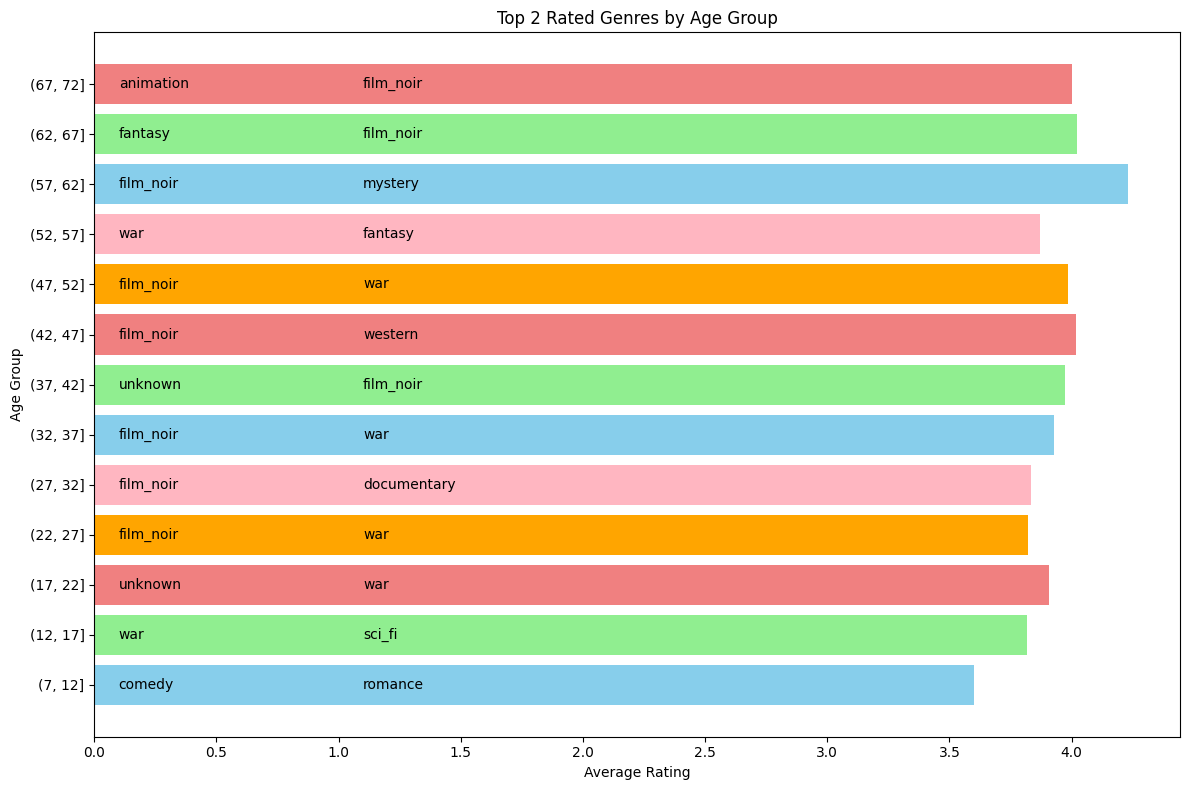

In [33]:
# Grouping by occupation and genre, and calculating the average rating
occupation_genre_avg_rating = df_exploded.groupby(['occupation', 'genre'])['rating'].mean().unstack() 
top_2_genres_by_occupation = {}
for occupation in occupation_genre_avg_rating.index:
    top_2_genres = occupation_genre_avg_rating.loc[occupation].nlargest(2).index.tolist()
    top_2_genres_by_occupation[occupation] = top_2_genres
    
fig, ax = plt.subplots(figsize=(12, 8))

for i, (occupation, top_genres) in enumerate(top_2_genres_by_occupation.items()):
    avg_rating = occupation_genre_avg_rating.loc[occupation, top_genres].mean()
    ax.barh(occupation, avg_rating,  label=occupation)
    for j, genre in enumerate(top_genres):
        ax.text(j + 0.1, i, genre, fontsize=10, va='center')

ax.set_xlabel('Average Rating')
ax.set_ylabel('Occupation')
ax.set_title('Top 2 Rated Genres by Occupation')
plt.tight_layout()
plt.show()

# Grouping by Age group and genre, and calculating the average rating

age_genre_avg_rating = df_exploded.groupby(['age_group', 'genre'])['rating'].mean().unstack() 
age_genre_avg_rating.fillna(0,inplace=True)
age_genre_avg_rating.index=age_genre_avg_rating.index.astype(str)
top_2_genres_by_age = {}
for age in age_genre_avg_rating.index:
    top_2_genres = age_genre_avg_rating.loc[age].nlargest(2).index.tolist()
    top_2_genres_by_age[age] = top_2_genres
    
fig, ax = plt.subplots(figsize=(12, 8))

for i, (age, top_genres) in enumerate(top_2_genres_by_age.items()):
    avg_rating = age_genre_avg_rating.loc[age, top_genres].mean()
    ax.barh(age, avg_rating,  label=age)
    for j, genre in enumerate(top_genres):
        ax.text(j + 0.1, i, genre, fontsize=10, va='center')

ax.set_xlabel('Average Rating')
ax.set_ylabel('Age Group')
ax.set_title('Top 2 Rated Genres by Age Group')
plt.tight_layout()
plt.show()

<h3> <span style="color:pink;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. Film_noir appears to be the most common genre among both groups. <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. Previously, we observed that “none,” “lawyer,” and “artist” gave the highest ratings among all occupations. This graph reaffirms these findings and also reveals the most popular genres among them. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3. The 57-62 age group gave the highest ratings, and their favorite genres are “film_noir” and “mystery.” While film_noir is popular across all age groups, mystery isn’t as favored among other age groups.

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Movie Popularity</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Plot the number of ratings received by each movie to identify popular movies and potentially recommend them more frequently.

In [34]:
df_visualization_grouped=df_visualization.groupby(["movie_id","movie_title"])["rating"].sum().nlargest(10)

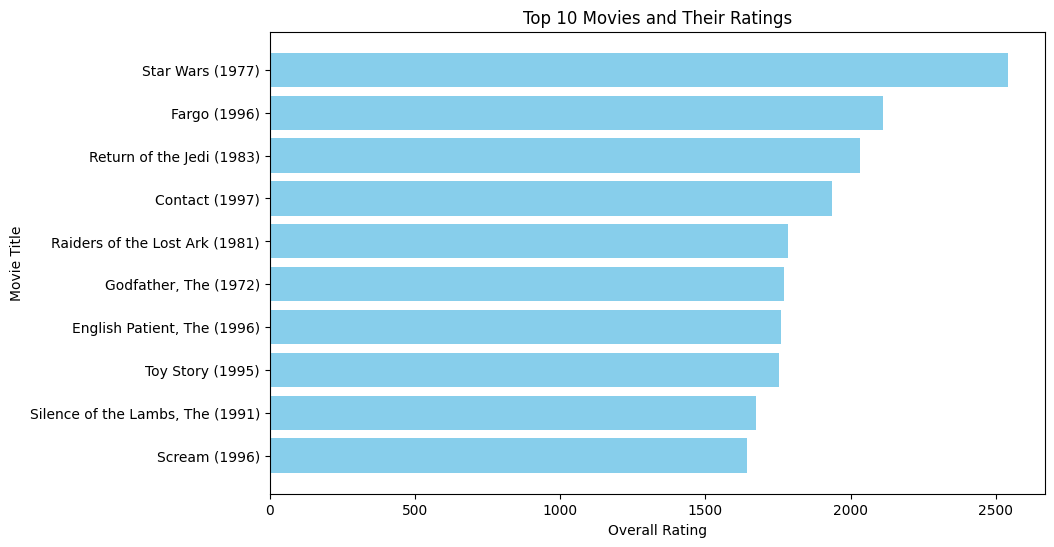

In [35]:
movies = df_visualization_grouped.index.get_level_values('movie_title')
ratings = df_visualization_grouped.values

plt.figure(figsize=(10, 6))
plt.barh(movies, ratings)
plt.xlabel('Overall Rating')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies and Their Ratings')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest rating at the top
plt.show()

<h3> <span style="color:pink;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We have top 10 movies in case the user is new we can recommend these to them.

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Trend Analysis</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Lets do trend analysis. How user preferences change over time. We can visualize trends in ratings or genre preferences over different time periods. We need to create some extra extra feature and for that we will copy our existing dataframe to new dataframe which we will use for this visualization

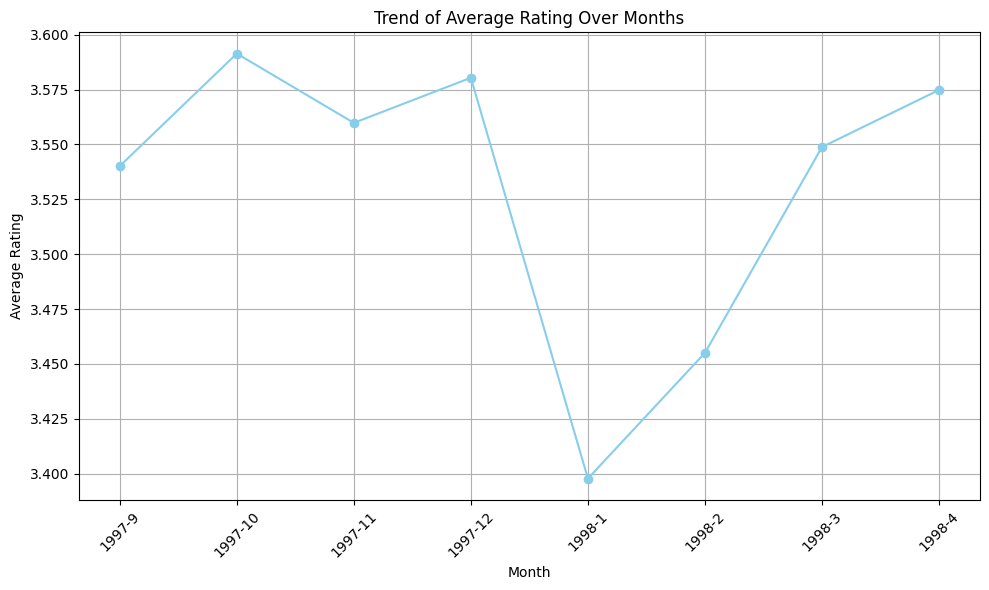

In [36]:
df=df_visualization.copy()
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

# Group by year and month, and calculate average rating
average_rating_by_date = df.groupby(['year', 'month'])['rating'].mean()

# Reset index to convert the groupby result into a DataFrame
average_rating_by_date = average_rating_by_date.reset_index()
average_rating_by_date['year-month']=average_rating_by_date['year'].astype(str) +'-'+ \
average_rating_by_date['month'].astype(str)

# Plot the trend of average rating over months
plt.figure(figsize=(10, 6))
plt.plot(average_rating_by_date['year-month'], average_rating_by_date['rating'], marker='o')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.title('Trend of Average Rating Over Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

<h3> <span style="color:pink;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation</span></h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; To be honest, we cannot determine the trend from just 8 months of data. While the graph suggests that movies received the lowest ratings in January, this could be due to holidays. However, we need more data to accurately identify the trend.

# user item matrix
Lets create user item matrix. Visually it won't help much as it will be sparse. But still we will create it as it is the core of the collaborative system. Later we will try to understand it better using colormap /heatmap.  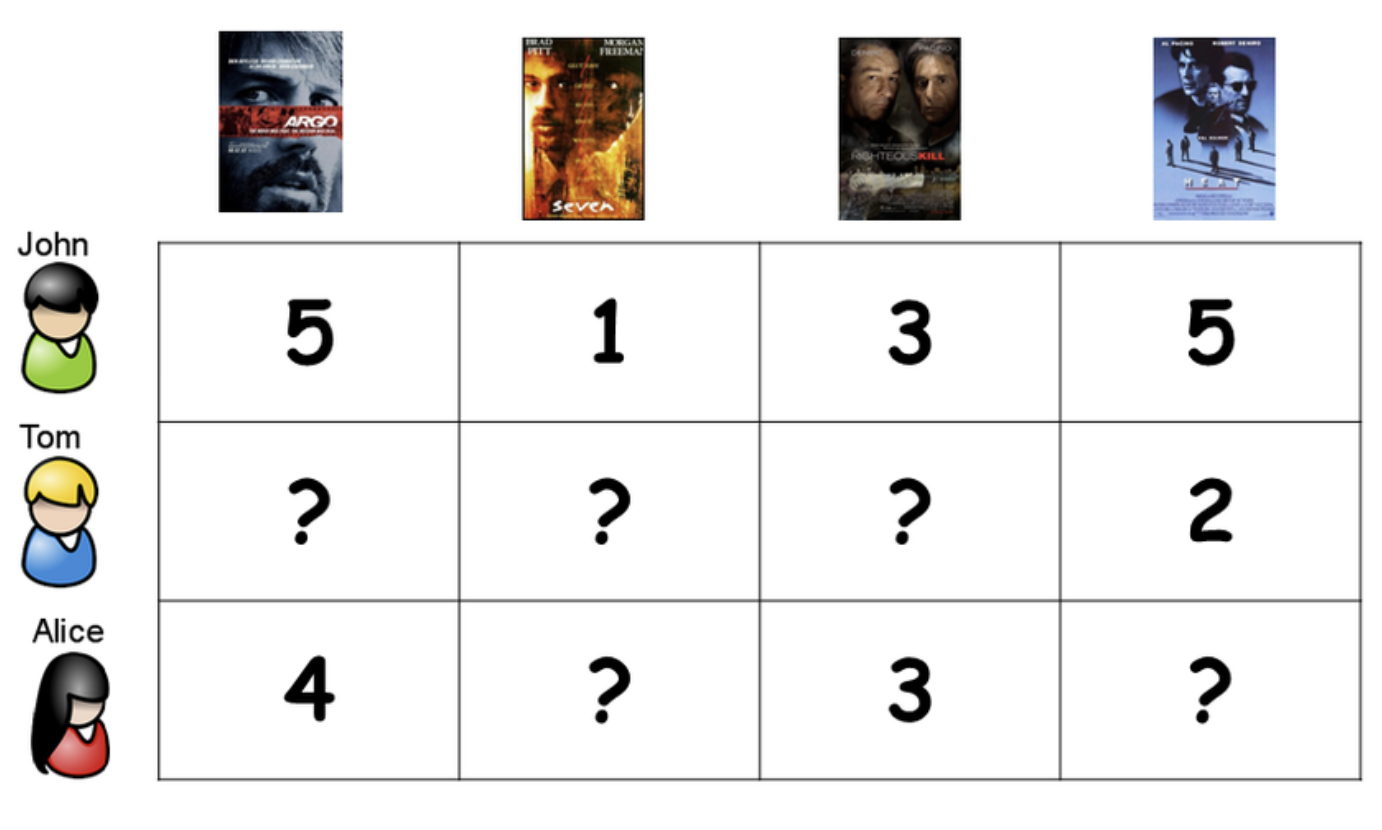
Image Source:-researchgate

In [37]:
user_item_matrix= df_visualization.pivot_table(index = 'user_id', columns = 'movie_id', values = 'rating', \
                                               aggfunc = 'sum', fill_value = 0)
user_item_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,5,4,1,5,3,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
940,0,0,0,2,0,0,4,5,3,0,...,0,0,0,0,0,0,0,0,0,0
941,5,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As expected, we couldn’t derive much insight from this visualization. However, now we can observe how our model interprets the user-item matrix. We can think this matrix as two 1D matrices: the user matrix and the item matrix, where each movie ID and user ID is a vector. Now, we have the option to use the similarity/distance between each movie and user manually, or we can utilize inbuilt models. Today, we will use inbuilt library to build our model. Let’s start!!!

<h1> <span style="color:red;"> Step 3:- Build Model</span></h1>

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;1. Analyze Features </span></h2><br>Here, we have three distinct sets of data that are useful for different types of recommender systems. We can build multiple systems and ultimately create a hybrid model that considers all aspects of the data. Let’s explore how we will use our data:: <br><br>
1. User ID, movie ID, and rating can be used for collaborative recommender systems. Today, we will focus on building one.<br>
2.	Movie details, such as genre, can serve as features for a content-based recommender system.<br>
3.	User details, including gender, age, and occupation, can help cluster users and further refine recommendations.<br><br>

We have previously developed a content-based recommendation system, now we will create one collaborative recommender systems. Later, I will try to create a hybrid system that integrates all features to enhance the recommendation for users. Now, let’s proceed with our first collaborative recommender system.

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;2. Data Preprocessing </span></h2> <br> Before starting the collaborative process, we first confirm whether the dataset is suitable for collaborative filtering. If we are sure then we will keep only the useful data and discard irrelevant data which won’t contribute to the recommendation system.<br><br>

1.	We will check if collaborative model if suitable for our dataset; if not suitable, we will terminate the process.<br>
2.	We will eliminate unnecessary columns, as previously done.<br>
3.	We will retain data only for active users.<br>
4.	We will consider only movies with a certain number of ratings.

In [38]:
movie_recommender_df.drop(columns=dropped_feature,inplace=True)

In [39]:
movie_recommender_df.shape

(100000, 28)

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Identify Active Users</span></h3>  We need to find users who consistently provide ratings for a significant number of movies. These users, whom we can also consider as experts, watch multiple movies and give multiple ratings.

In [40]:
active_users=movie_recommender_df.groupby('user_id')['rating'].count()>50
active_user_ids=active_users[active_users].index.to_list()

In [41]:
movie_recommender_df=movie_recommender_df[movie_recommender_df['user_id'].isin(active_user_ids)]

In [42]:
movie_recommender_df.shape

(88221, 28)

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Identify Popular Movies</span></h3> We will focus on movies that have received a certain number of ratings.

In [43]:
popular_movies=movie_recommender_df.groupby('movie_id')['rating'].count()>25
popular_movie_ids=popular_movies[popular_movies].index.to_list()

In [44]:
movie_recommender_df=movie_recommender_df[movie_recommender_df['movie_id'].isin(popular_movie_ids)]

In [45]:
movie_recommender_df.shape

(81075, 28)

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Data Sparsity Check</span></h3>  We calculate the sparsity of the dataset to determine if it's too sparse for collaborative filtering. If the data is very sparse (e.g., less than 0.5% filled), collaborative filtering might not be the best option.

In [46]:
total_elements = user_item_matrix.shape[0] * user_item_matrix.shape[1]
non_zero_elements = np.count_nonzero(user_item_matrix)

sparsity_percentage = (1 - (non_zero_elements / total_elements)) * 100

if sparsity_percentage < 0.5:
    print("The dataset may be too sparse for collaborative filtering. We need to abort the process.")
else:
    print("The dataset seems suitable for collaborative filtering. We will continue the process.")

The dataset seems suitable for collaborative filtering. We will continue the process.


<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;3. Model Selection </span></h2> <br>Core datastructure for collaborative filtering is <b>matrix factorization</b>. There are many matrix factorization techniques such as Singular Value Decomposition (SVD) or Alternating Least Squares (ALS) etc.<br>For this purpose we have many inbuilt python libraries like surprise, implicit, or LightFM. Here we have explicit data so we will choose surprise library.<br>Surprise provides various algorithms such as Singular Value Decomposition (SVD), K-Nearest Neighbors (KNN), and Non-Negative Matrix Factorization (NMF) etc. SVD is a good starting point and often provides good performance. so will start with SVD.

In [47]:
#earlier we seen our dataset rating ranges from 1-5. Using that info we'll load the dataset into Surprise's format.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(movie_recommender_df[['user_id', 'movie_id', 'rating']], reader)

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Bias Handling</span></h3>  We choose the SVD algorithm with biased handling, which considers user and item biases. This helps in handling both optimistic and pessimistic users.

In [48]:
model=SVD(biased=True)

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;4. Train-Test Split </span></h2> Like scikit learn train test split method, we can split our data randomly in surprise model while ensuring that each user and item in the test set exists in the training set to avoid the "cold start" problem. It only works with Dataset object,that is why earlier we have converted our data to this type.

In [49]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;5. Model Training </span></h2>

In [50]:
model.fit(trainset)
test_predictions = model.test(testset)

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;5. Model Evaluation </span></h2> Evaluate the performance of your model using appropriate evaluation metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), or precision-recall curves.
Cross-validation techniques can help provide more robust estimates of model performance.

In [51]:
# Evaluate the model using RMSE
accuracy.rmse(test_predictions)

RMSE: 0.9036


0.903603622654277

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;6. Build Recommender System </span></h2> 

In [52]:
unrated_items = trainset.build_anti_testset() #generate user-item pairs with mising ratings in the training set
train_predictions = model.test(unrated_items)
all_predictions=test_predictions+train_predictions

recommended_items = {} #to store recommended items for each user

# Process predictions to find top-N recommendations for each user
for uid, iid, true_r, est, _ in all_predictions:
    if uid not in recommended_items:
        recommended_items[uid] = []
    recommended_items[uid].append((iid, est))

In [53]:
#store it in variable so that we do not need to fetch the value everytime
top_n_all_time_popular_movies = movie_recommender_df.groupby('movie_id')['rating'].mean()    
    
# Function to recommend top-N movies for every user
def top_n_movie_recommendations(user_id,n):
    # if this thorws error that means user does not give rating frequently we need to show the person 
    # all time hit movies or something similar 👇
    try:
        user_item_rating_list=recommended_items[user_id]
        user_item_rating_list=sorted(user_item_rating_list, key=lambda x: x[1], reverse=True)
        top_n_movie_ids = [movie_id for movie_id,_ in user_item_rating_list[0:n]]
    except Exception as e:
        # recommend top-N most popular movies
        top_n_movie_ids = top_n_all_time_popular_movies.nlargest(n).index.to_list()
        print(top_n_movie_ids)
    top_n_movie_titles = movies_df[movies_df['movie_id'].isin(top_n_movie_ids)]['movie_title']
    return top_n_movie_titles.tolist()

In [54]:
top_n_movie_recommendations(334,5)

['Silence of the Lambs, The (1991)',
 'Wrong Trousers, The (1993)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'Third Man, The (1949)']

In [55]:
top_n_movie_recommendations(63,5)

['Godfather, The (1972)',
 'Jean de Florette (1986)',
 '12 Angry Men (1957)',
 'North by Northwest (1959)']

In [56]:
top_n_movie_recommendations(474,7)

['Star Wars (1977)',
 'Blade Runner (1982)',
 'Jean de Florette (1986)',
 'Wrong Trousers, The (1993)',
 'Close Shave, A (1995)']

In [57]:
movie_recommender_df[movie_recommender_df['user_id']==4] #user 4 does not exists

,user_id,age,gender,occupation,zip_code,movie_id,rating,timestamp,movie_title,unknown,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western


In [58]:
top_n_movie_recommendations(4,10) # it should recommend top 10 most popular movies

[318, 408, 483, 169, 64, 114, 603, 50, 12, 963]


['Usual Suspects, The (1995)',
 'Star Wars (1977)',
 'Shawshank Redemption, The (1994)',
 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 'Wrong Trousers, The (1993)',
 "Schindler's List (1993)",
 'Close Shave, A (1995)',
 'Casablanca (1942)',
 'Rear Window (1954)',
 'Some Folks Call It a Sling Blade (1993)']

<h1> <span style="color:red;"> Step 4:- Conclusion</span></h1>

1. Here, we have used only SVD as our model. We should try multiple models before confirming the best one. Later, we will try the NMF model and some others to see which works best for our dataset. We have also skipped cross-validation and hyperparameter tuning, which we will try as well.<br>


2. During the visualization, we saw how user demographics influence ratings and genres. We have not used these features in our model, nor have we considered content-based recommendations using genres. Later, I will try to use these features to fine-tuning our model further.